### Проведите декомпозицию ряда на составляющие для того, чтобы получить стационарный ряд. Сделайте проверку получившегося ряда тестом Дики — Фуллера

In [81]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
register_matplotlib_converters()
from time import time
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Данные

In [176]:
df=pd.read_csv('D_QM_05_01_AirPassengers.csv')

In [177]:
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])

In [178]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


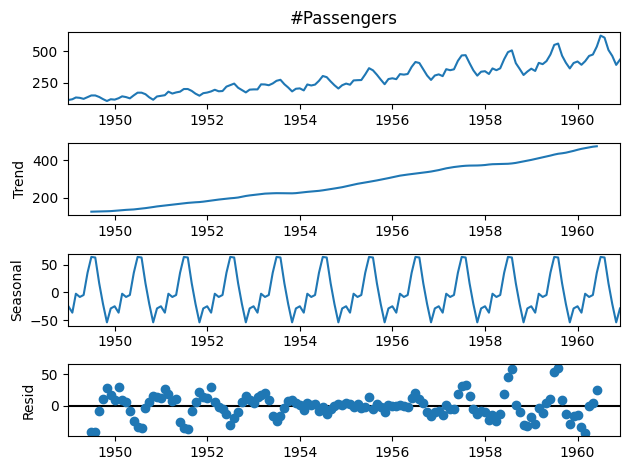

In [179]:
dec = seasonal_decompose(df['#Passengers']).plot()
plt.show()

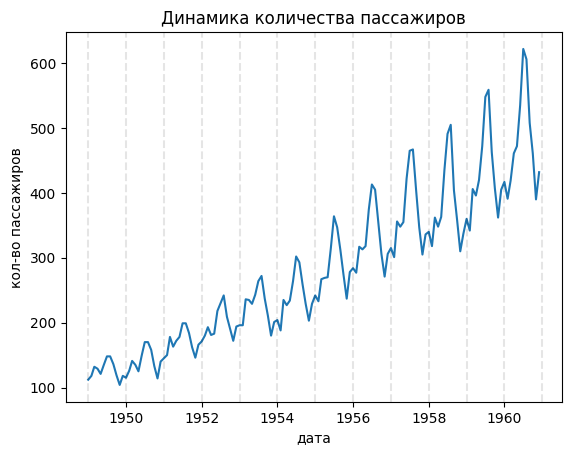

In [180]:
plt.plot(df)
plt.title('Динамика количества пассажиров')
plt.xlabel('дата')
plt.ylabel('кол-во пассажиров')
for year in range(1949,1962):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),
                color='k', linestyle='--', alpha=0.1)
plt.show()

По графикам наблюдается возрастающий тренд, годовая сезонность и непостоянство дисперсии (гетероскедантичность) => ряд нестационарный.

# Приведение ряда к стационарному

## Коррекция гетероскедантичности

Для избавления от гетероскедантичности прологорифмируем ряд.

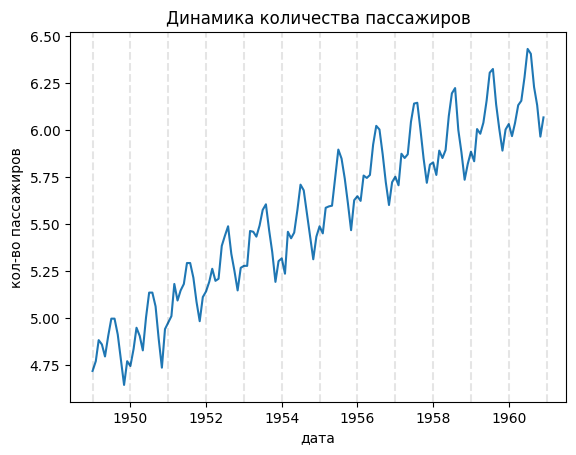

In [181]:
df_log=np.log(df)
plt.plot(df_log)
plt.title('Динамика количества пассажиров')
plt.xlabel('дата')
plt.ylabel('кол-во пассажиров')
for year in range(1949,1962):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),
                color='k', linestyle='--', alpha=0.1)
plt.show()

## Расчет разностей 1-го порядка

Для избавления от тренда продифференцируем временной ряд один раз.

In [182]:
first_diff = df_log.diff()[1:]

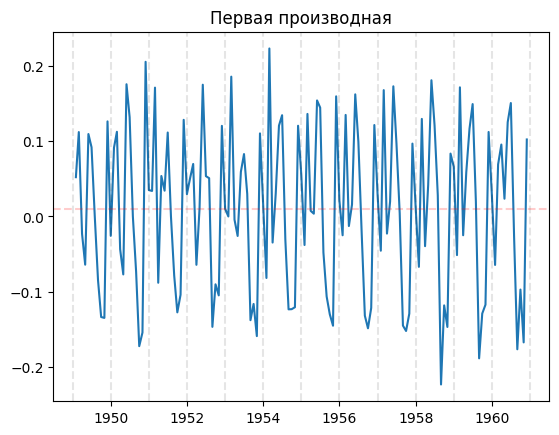

In [183]:
plt.plot(first_diff)
plt.title('Первая производная')
for year in range(1949,1962):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.1)
plt.axhline(first_diff['#Passengers'].mean(), color='r', alpha=0.2, linestyle='--')
plt.show()

### Тест Дики — Фуллера

In [184]:
test = sm.tsa.adfuller(first_diff)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if (test[0]> test[4]['5%']): 
    print ('Единичные корни есть - ряд не стационарен')
else:
   print ('Единичных корней нет - ряд стационарен')

adf:  -2.717130598388114
p-value:  0.07112054815086184
Critical values:  {'1%': -3.4825006939887997, '5%': -2.884397984161377, '10%': -2.578960197753906}
Единичные корни есть - ряд не стационарен


## Расчет разностей 2-го порядка

Так как имеются единичные корни - продифференцируем ряд еще раз.

In [185]:
second_diff = first_diff.diff()[1:]

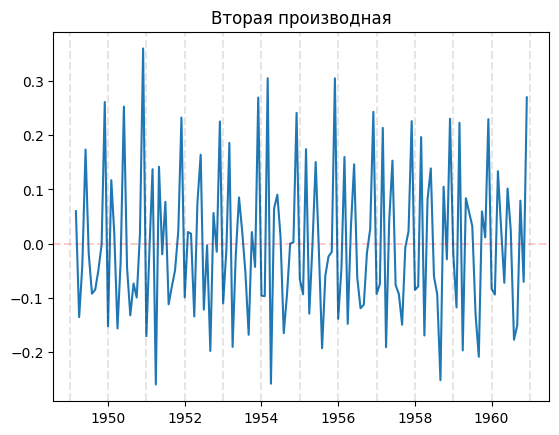

In [186]:
plt.plot(second_diff)
plt.title('Вторая производная')
for year in range(1949,1962):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.1)
plt.axhline(second_diff['#Passengers'].mean(), color='r', alpha=0.2, linestyle='--')
plt.show()

### Тест Дики — Фуллера

In [187]:
test = sm.tsa.adfuller(second_diff)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if (test[0]> test[4]['5%']): 
    print ('Единичные корни есть - ряд не стационарен')
else:
   print ('Единичных корней нет - ряд стационарен')

adf:  -8.19662913218224
p-value:  7.419304549376186e-13
Critical values:  {'1%': -3.4825006939887997, '5%': -2.884397984161377, '10%': -2.578960197753906}
Единичных корней нет - ряд стационарен


Получили стационарный ряд.

# Дополнительно: Модель ARIMA

### ACF/PACF
Построим функции авокорреляции и частной автокорреляции.
Вычислим параметры p и q для модели ARIMA.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


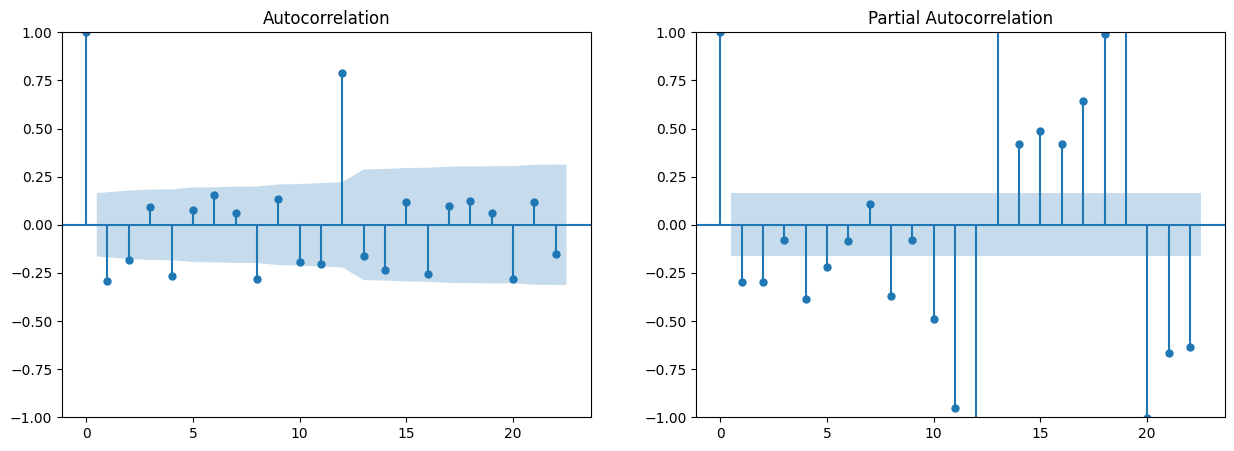

In [102]:
fig = plt.figure(figsize=(15, 5))
layout = (1, 2)
acf_ax = plt.subplot2grid(layout, (0, 0))
pacf_ax = plt.subplot2grid(layout, (0, 1))
plot_acf(second_diff, ax=acf_ax)
plot_pacf(second_diff, ax=pacf_ax)
plt.show()

Графики указывают на выбор параметров p = 12 и q = 4.

Для избавления от тренда продифференцируем временной ряд один раз => d = 1.

Построим модель с параметрами ARIMA(12,0,4)

## Обучение модели

In [103]:
# Делим датасет на обучающую и тестовую выборки
train_data = second_diff[:106]
test_data = second_diff[106:]

In [155]:
model = sm.tsa.arima.ARIMA(second_diff, order=(12,0,4))
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using z

Model Fitting Time: 1.5952322483062744


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [156]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  142
Model:                ARIMA(12, 0, 4)   Log Likelihood                 224.188
Date:                Fri, 07 Apr 2023   AIC                           -412.376
Time:                        10:09:03   BIC                           -359.171
Sample:                    03-01-1949   HQIC                          -390.755
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.001      0.117      0.907      -0.002       0.002
ar.L1         -0.0389      0.213     -0.183      0.855      -0.456       0.378
ar.L2         -0.1034      0.221     -0.467      0.6

## Прогноз модели

In [157]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data['#Passengers'] - predictions

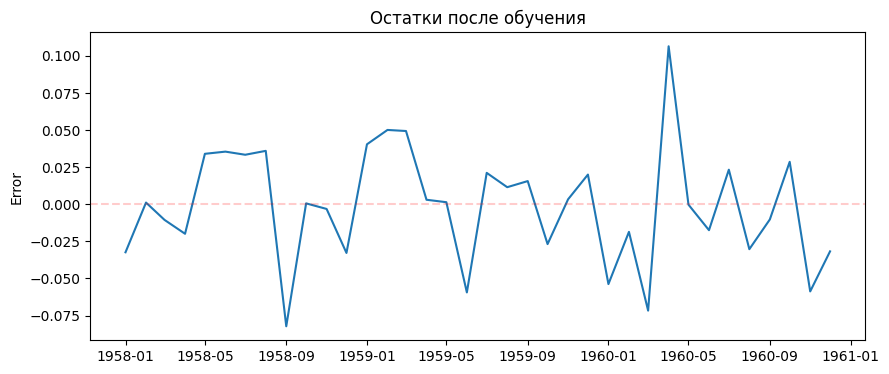

In [158]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Остатки после обучения')
plt.ylabel('Error')
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
plt.show()

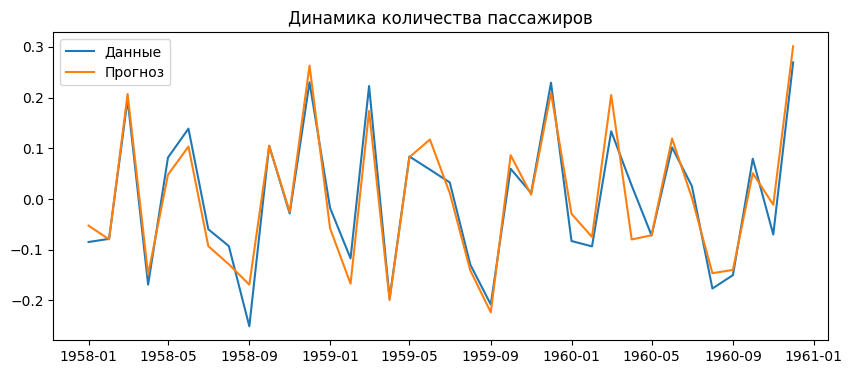

In [159]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(('Данные', 'Прогноз'))
plt.title('Динамика количества пассажиров')
plt.show()

In [160]:
print('Сумма квадратов ошибок:', np.sqrt(np.mean(residuals**2)))

Сумма квадратов ошибок: 0.038380456073460356
